# Redundancy Simulation

Simulation to test how simulation dropb to zero as more independent clusters are added to an ensamble

In [1]:
library(tidyverse)
library(dplyr)
library(ggplot2)
library(latex2exp)
library(patchwork)

set.seed(1)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.1     ✔ stringr   1.5.2
✔ ggplot2   4.0.0     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [6]:
max_clusters <- 50
num_iterations <- 1000

cluster_total_abundance <- 100

# Cumulative structures
results <- tibble(
    iteration = integer(),
    num_clusters = integer(),
    Simpson = numeric(),
    Redundancy = numeric(),
    Multiplicity = numeric(),
)

for(k in 1:num_iterations)
{

    # Cumulative structures
    # Unclustered
    ab <- c()
    diss <- c()

    # Clustered
    ab_clust <- c()
    diss_clust <- c()

    redun <- c()
    dmult <- c()
    simp <- c()

    for(i in 1:max_clusters)
    {
        new_size <- ceiling(runif(n = 1,min = 3, max = 15))
        new_ab <- as.vector(t(rmultinom(1, size = cluster_total_abundance, prob = sample(1:5, new_size, replace = TRUE))))
        # Dissimilarity Matrix
        new_diss <- matrix(runif(n = new_size*new_size, min = 0.1, max = 1), ncol = new_size, nrow = new_size)
        diag(new_diss) <- 0
        new_diss <- (new_diss + t(new_diss))/2

        # Initial iteration
        if(length(ab) == 0)
        {
            ab <- new_ab
            ab_clust <- cluster_total_abundance

            diss <- new_diss
            diss_clust <- as.matrix(0)                
        }
        else {
        
            ab <- c(ab, new_ab)
            ab_clust <- c(ab_clust, cluster_total_abundance)

            diss_clust <- matrix(1, nrow = length(ab_clust), ncol = length(ab_clust))
            diag(diss_clust) <- 0

            old_diss <- diss
            old_size <- ncol(old_diss)
            diss <- matrix(1, ncol = old_size + new_size, nrow = old_size + new_size)
            diss[1:old_size, 1:old_size] <- old_diss
            diss[(old_size+1):(old_size+new_size), (old_size+1):(old_size+new_size)] <- new_diss
            
        }

        # Computes
        simp <- c(simp, vegan::diversity(ab, index = "simpson"))
        redun <- c(redun, divermeta::redundancy(ab = ab, diss = diss))
        dmult <- c(dmult, divermeta::multiplicity.distance(ab = ab, diss = diss, ab_clust = ab_clust, diss_clust = diss_clust, sig = 1))

    }


    results <- rbind(results, tibble(
            iteration = k,
            num_clusters = 1:length(ab_clust),
            Redundancy = redun,
            Multiplicity = dmult,
            Simpson = simp
        ))

}



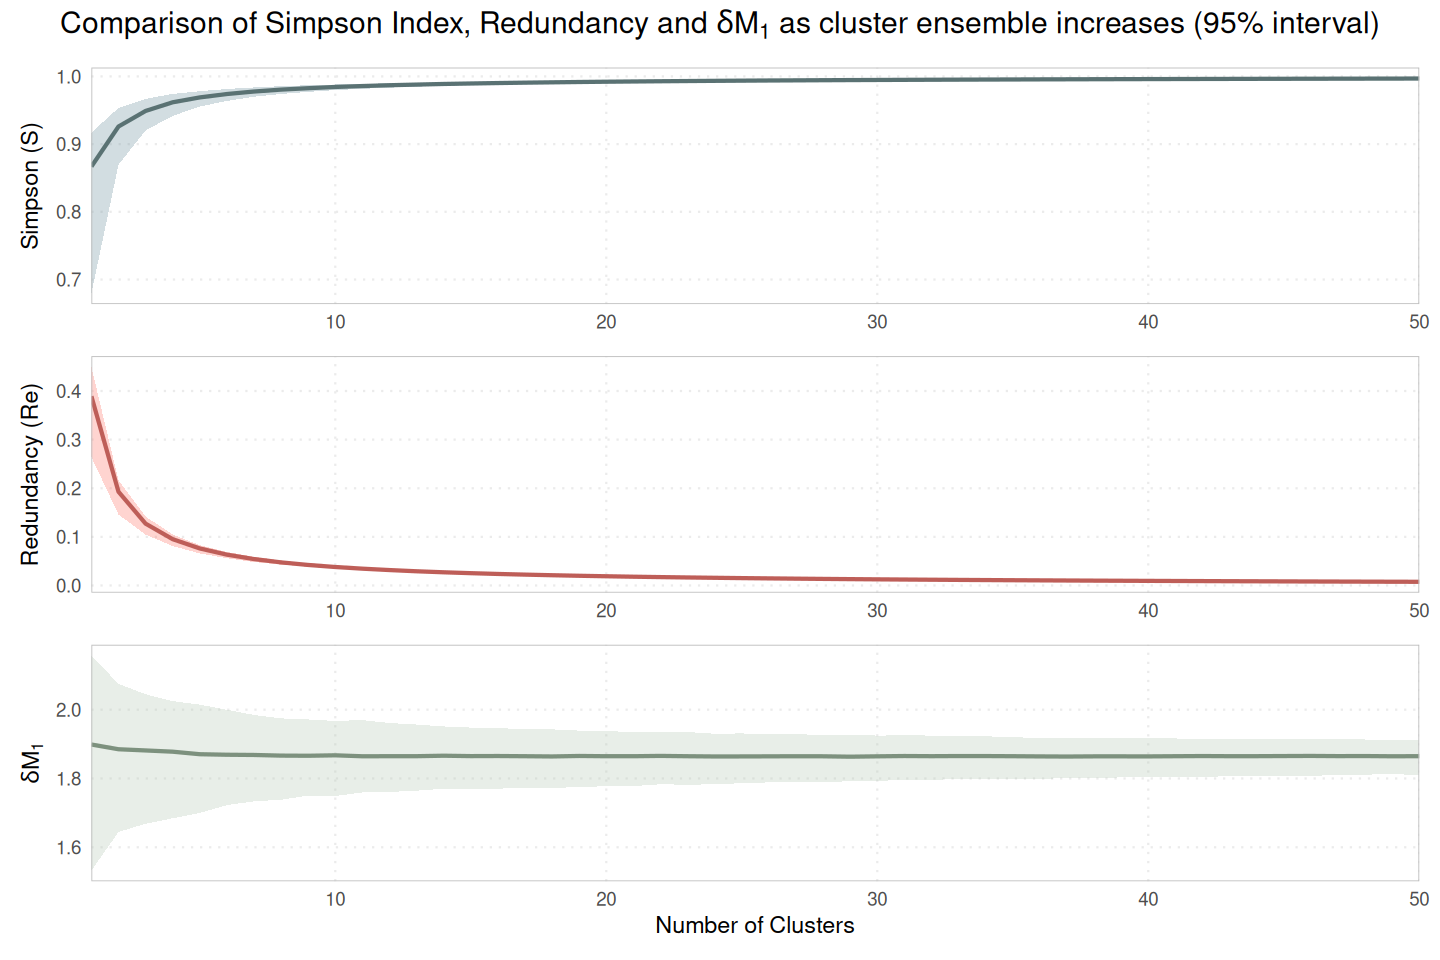

In [7]:



custom_shaded_lineplot <- function(data, x_var, y_var, x_label, y_label, plot_title, shaded_color, strong_color) {
  
  # Convert string inputs to symbols for unquoting in tidyverse functions (NSE)
  # rlang::sym is used to convert the string column name into a variable name
  x_sym <- rlang::sym(x_var)
  y_sym <- rlang::sym(y_var)
  
  # A. Summarize the Data
  # Group by the x variable and calculate median/quantiles for the y variable
  summary_data <- data %>%
    group_by(!!x_sym) %>%
    summarise(
      median_y = median(!!y_sym, na.rm = TRUE),
      # Calculate 2.5th percentile (lower bound of 95% interval)
      lower_95 = quantile(!!y_sym, 0.025, na.rm = TRUE),
      # Calculate 97.5th percentile (upper bound of 95% interval)
      upper_95 = quantile(!!y_sym, 0.975, na.rm = TRUE),
      .groups = 'drop'
    )
  
  # B. Generate the ggplot
  plot <- summary_data %>%
    ggplot(aes(x = !!x_sym, y = median_y)) +
    
    # 1. Shaded Area (95% Interval) using geom_ribbon
    geom_ribbon(
      aes(ymin = lower_95, ymax = upper_95), 
      fill = shaded_color, 
      alpha = 0.3      
    ) +
    
    # 2. Median Line (The main line) using geom_line
    geom_line(
      linewidth = 1.2, 
      color = strong_color
    ) +
    
    # Customize Aesthetics
    labs(
      title = plot_title,
      x = x_label,
      y = y_label
    ) +
    scale_x_continuous(expand = c(0, 0)) + # Start x-axis at 0
    
    # Clean Theme
    theme_minimal(base_size = 14) +
    theme(
      plot.title = element_text(hjust = 0.5),
      panel.grid.minor = element_blank(),
      panel.grid.major.x = element_line(linetype = "dotted"),
      panel.grid.major.y = element_line(linetype = "dotted")
    )
    
  return(plot)
}

simpson_plot <- custom_shaded_lineplot(
  data = results,
  x_var = "num_clusters",
  y_var = "Simpson",
  x_label = NULL,
  y_label = "Simpson (S)",
  plot_title = NULL,
  shaded_color = "#6A8D9A",  
  strong_color = "#5A7273"
)

redundancy_plot <- custom_shaded_lineplot(
  data = results,
  x_var = "num_clusters",
  y_var = "Redundancy",
  x_label = NULL,
  y_label = "Redundancy (Re)",
  plot_title = NULL,
  shaded_color = "#FF6F61",  
  strong_color = "#BE5E58"
)

multiplicity_plot <- custom_shaded_lineplot(
  data = results,
  x_var = "num_clusters",
  y_var = "Multiplicity",
  x_label = "Number of Clusters",
  y_label = TeX("$\\delta M_1$"),
  plot_title = NULL,
  shaded_color = "#B4C8B4", 
  strong_color = "#7D917E"  
)

  
plot_combined <- simpson_plot / redundancy_plot / multiplicity_plot

# 3d. Add a unified title and ensure shared axis scales
plot_final_titled <- plot_combined + 
  plot_annotation(
    title = TeX("Comparison of Simpson Index, Redundancy and $\\delta M_1$ as cluster ensemble increases (95% interval)"),
    theme = theme(plot.title = element_text(size = 18, hjust = 0.5))
  ) &
  # Apply consistent theme adjustments across both plots
  theme(plot.tag.position = c(0.05, 0.95), # Position the A and B tags
        plot.tag = element_text(size = 14, face = "bold"),
        panel.border = element_rect(colour = "gray", fill = NA, linewidth = 0.5))


options(repr.plot.width = 12, repr.plot.height = 8)

# Print the final combined plot
print(plot_final_titled)